In [1]:
from src import model as md

c:\Users\raulg\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## QIP Predictor

In [2]:
import pandas as pd

In [5]:
# conn, cursor = md.db_connect()
# df_supplier_quotes = pd.read_sql("SELECT * FROM suppliers_quotes",conn)
df_supplier_quotes = pd.read_csv('./data/csv/supplier_quotes.csv')
df_supplier_quotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   supplier_quote_id         162 non-null    int64  
 1   supplier_id               162 non-null    int64  
 2   product_id                162 non-null    int64  
 3   inquiry_id                162 non-null    int64  
 4   cost_average              162 non-null    float64
 5   cost_price                162 non-null    float64
 6   number_days               162 non-null    int64  
 7   distance                  162 non-null    int64  
 8   quote_performance         162 non-null    float64
 9   supplier_performance      162 non-null    float64
 10  quality_item_performance  162 non-null    float64
 11  accepted                  162 non-null    bool   
 12  query_date                162 non-null    object 
dtypes: bool(1), float64(5), int64(6), object(1)
memory usage: 15.5+ K

In [36]:
### This stores the data
df_supplier_quotes.to_csv('data/csv/supplier_quotes.csv', index=False)

In [6]:
df_sel = df_supplier_quotes[["cost_average","cost_price","number_days","distance","quote_performance","supplier_performance","accepted"]]
df_sel

,cost_average,cost_price,number_days,distance,quote_performance,supplier_performance,accepted
0,0.73,0.77,19,594,0.77,0.89,True
1,0.94,1.02,27,777,0.43,0.55,False
2,0.72,0.78,18,954,0.77,0.36,True
3,0.40,0.47,5,829,1.05,0.65,True
4,0.60,0.68,13,338,0.91,0.88,True
...,...,...,...,...,...,...,...
157,0.46,0.43,7,85,1.20,1.09,True
158,0.89,0.88,26,422,0.71,0.73,True
159,0.45,0.55,7,418,1.12,0.94,True
160,0.74,0.80,19,840,0.67,0.68,False


### Little EDA

In [21]:
df_sel['quality_item_performance'].describe()

count    162.000000
mean      80.055370
std        8.920266
min       62.840000
25%       73.242500
50%       79.460000
75%       86.115000
max      100.600000
Name: quality_item_performance, dtype: float64

In [25]:
df_sel['accepted'].value_counts()

accepted
True     112
False     50
Name: count, dtype: int64

In [7]:
import seaborn as sns

<Axes: >

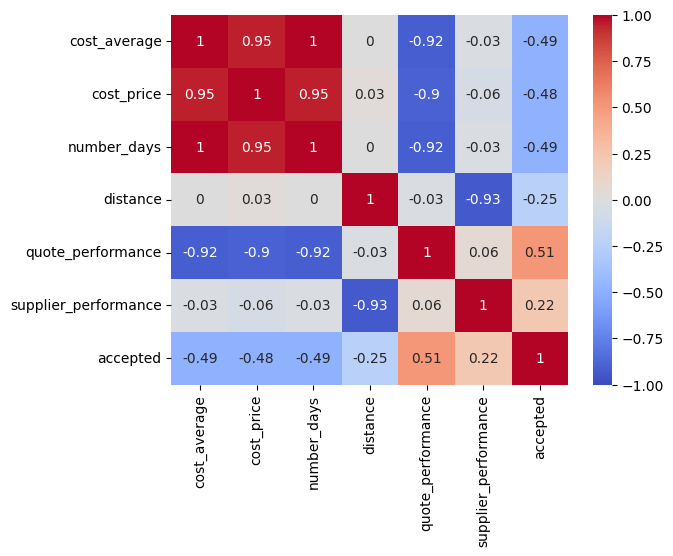

In [8]:
sns.heatmap(round(df_sel.corr(),2), vmin=-1,annot=True,cmap='coolwarm')

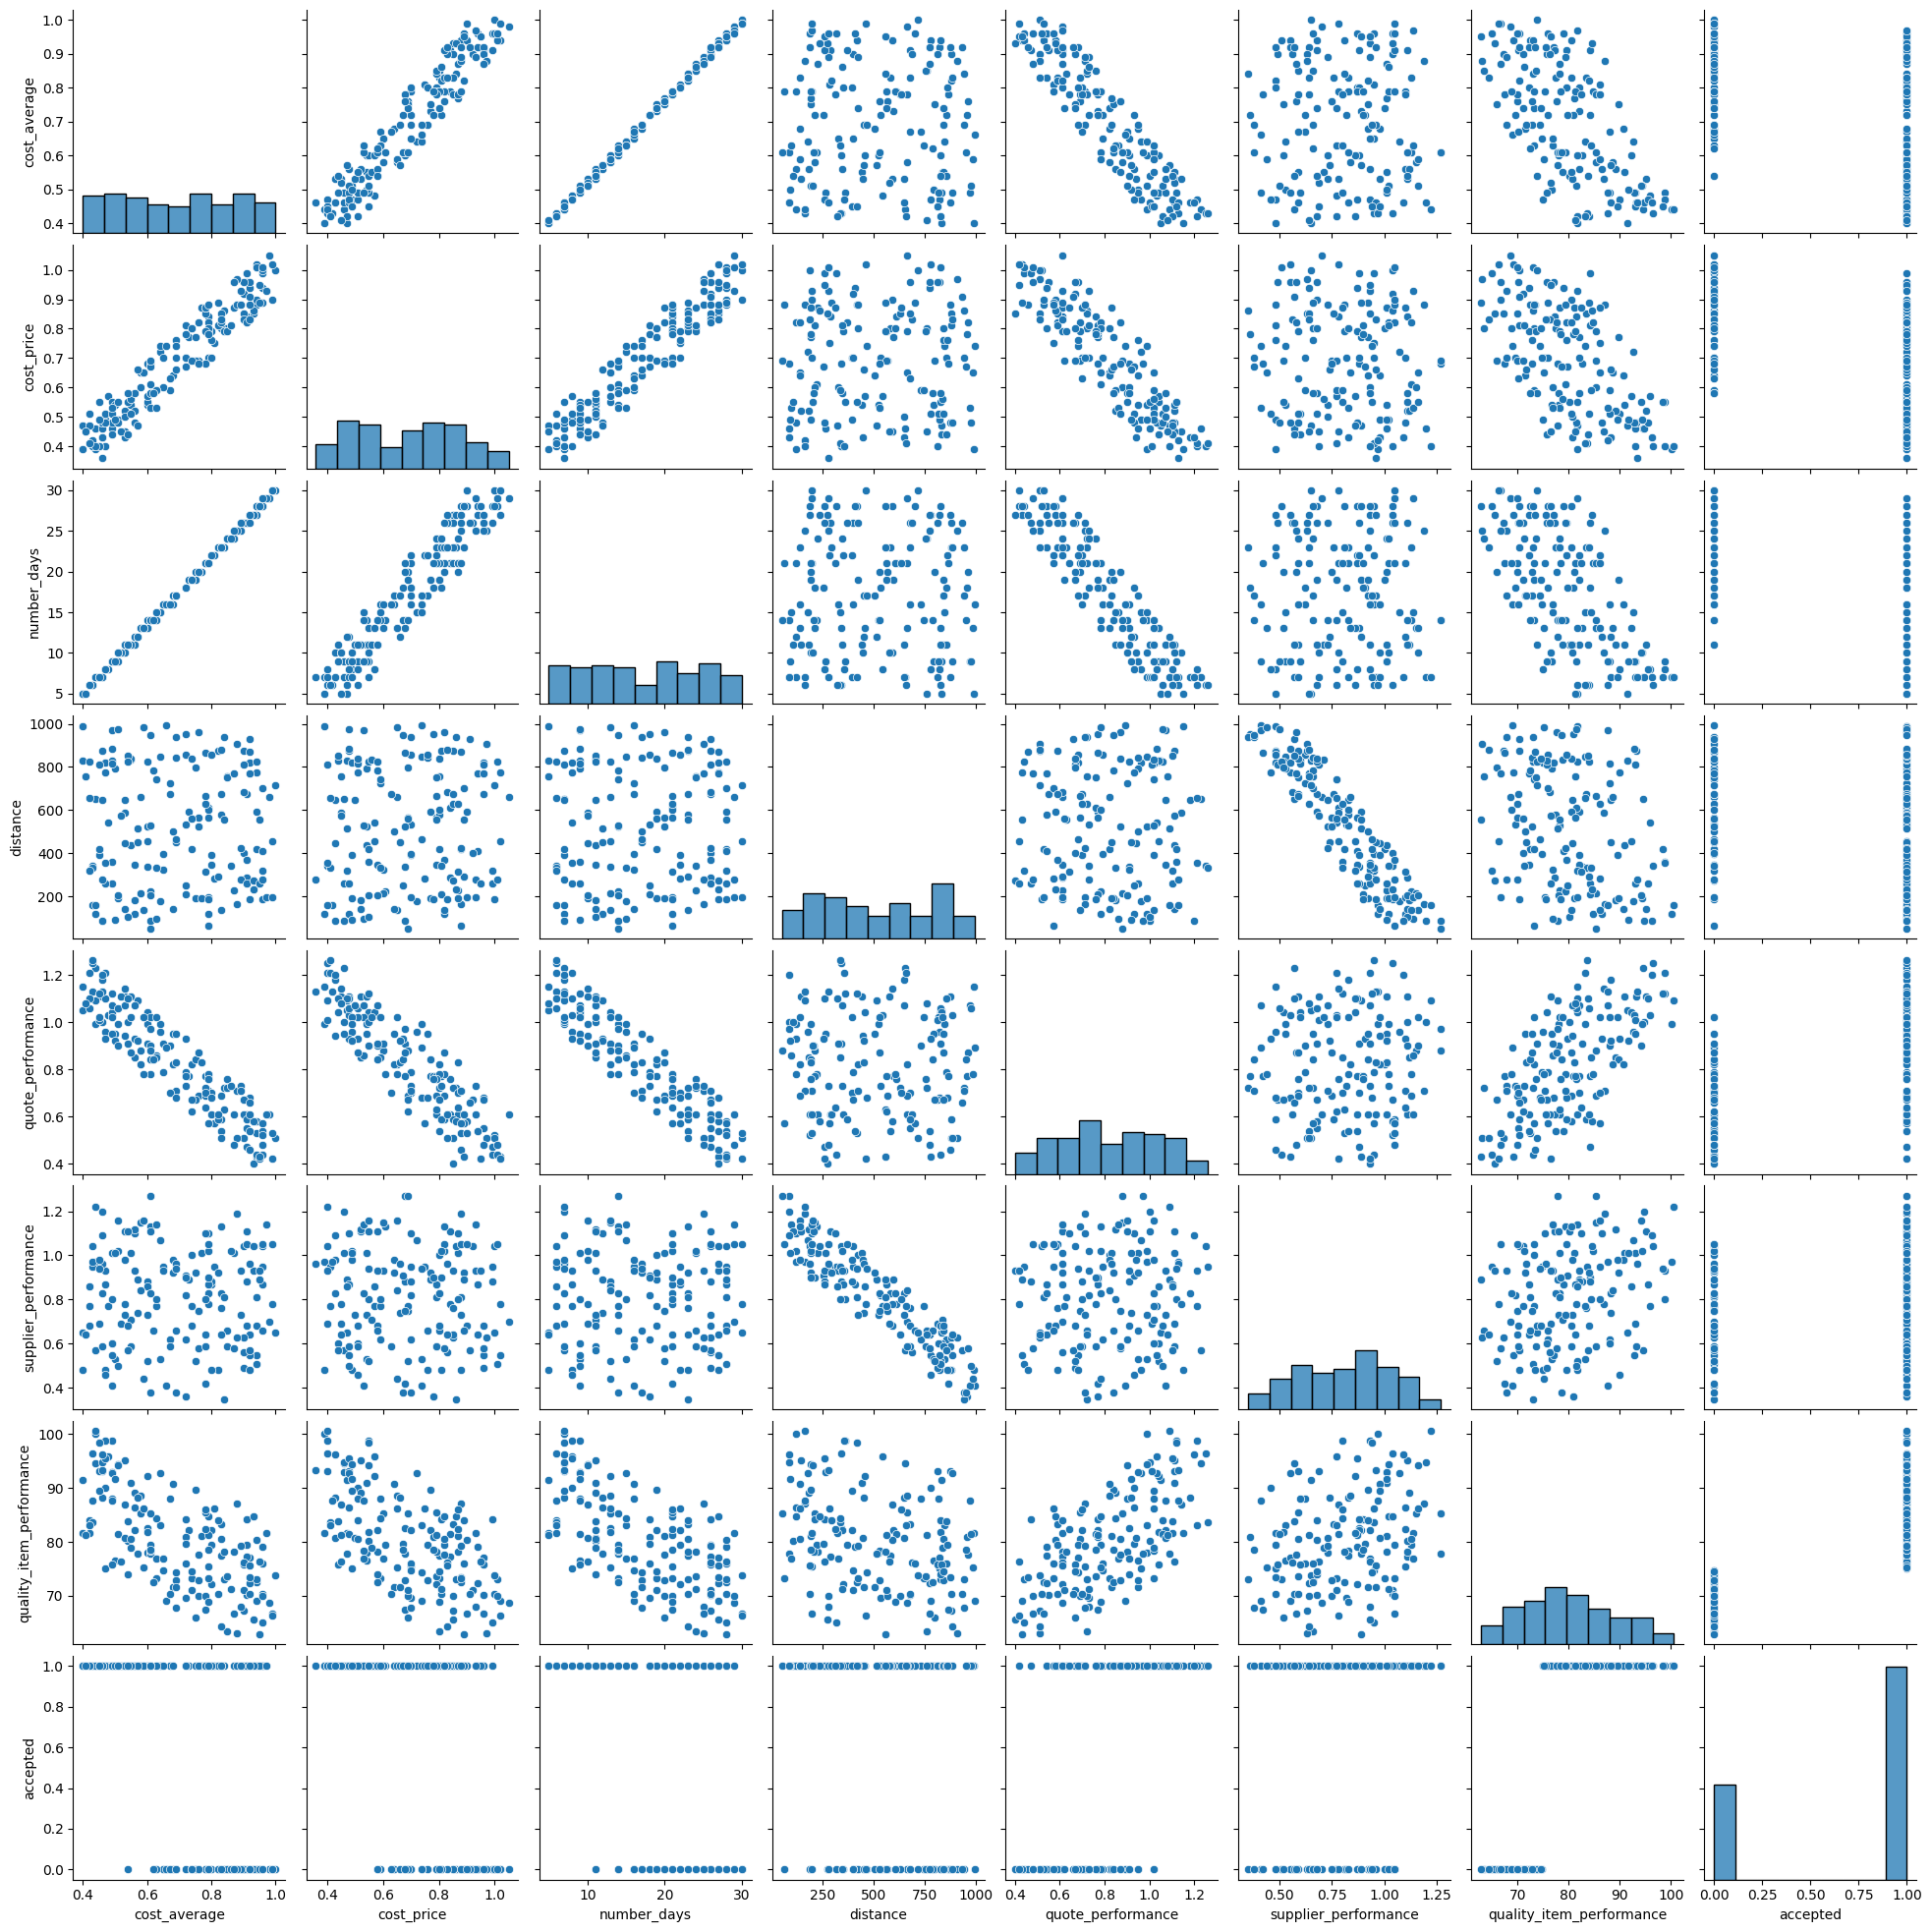

In [28]:
sns.pairplot(df_sel)

## Baseline QIP predictor model

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle

In [24]:
np.random.seed(42)
x1 = df_sel.drop(columns='accepted')
y1 = df_sel['accepted']
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1, test_size=.2)
dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(x1_train, y1_train)
y1_pred = dtc.predict(x1_test)
print('Accuracy', round(accuracy_score(y1_test, y1_pred),2))
print('ROC_AUC', round(roc_auc_score(y1_test, y1_pred),2))
print('Confussion matrix: \n', confusion_matrix(y1_test, y1_pred))



Accuracy 0.73
ROC_AUC 0.78
Confussion matrix: 
 [[ 9  1]
 [ 8 15]]


[Text(0.5, 0.875, 'cost_average <= 0.645\ngini = 0.428\nsamples = 129\nvalue = [40, 89]'),
 Text(0.3, 0.625, 'quote_performance <= 0.915\ngini = 0.064\nsamples = 60\nvalue = [2, 58]'),
 Text(0.4, 0.75, 'True  '),
 Text(0.2, 0.375, 'supplier_performance <= 0.74\ngini = 0.245\nsamples = 14\nvalue = [2, 12]'),
 Text(0.1, 0.125, 'gini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(0.3, 0.125, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(0.4, 0.375, 'gini = 0.0\nsamples = 46\nvalue = [0, 46]'),
 Text(0.7, 0.625, 'quote_performance <= 0.535\ngini = 0.495\nsamples = 69\nvalue = [38, 31]'),
 Text(0.6, 0.75, '  False'),
 Text(0.6, 0.375, 'gini = 0.0\nsamples = 12\nvalue = [12, 0]'),
 Text(0.8, 0.375, 'distance <= 334.0\ngini = 0.496\nsamples = 57\nvalue = [26, 31]'),
 Text(0.7, 0.125, 'gini = 0.219\nsamples = 16\nvalue = [2, 14]'),
 Text(0.9, 0.125, 'gini = 0.485\nsamples = 41\nvalue = [24, 17]')]

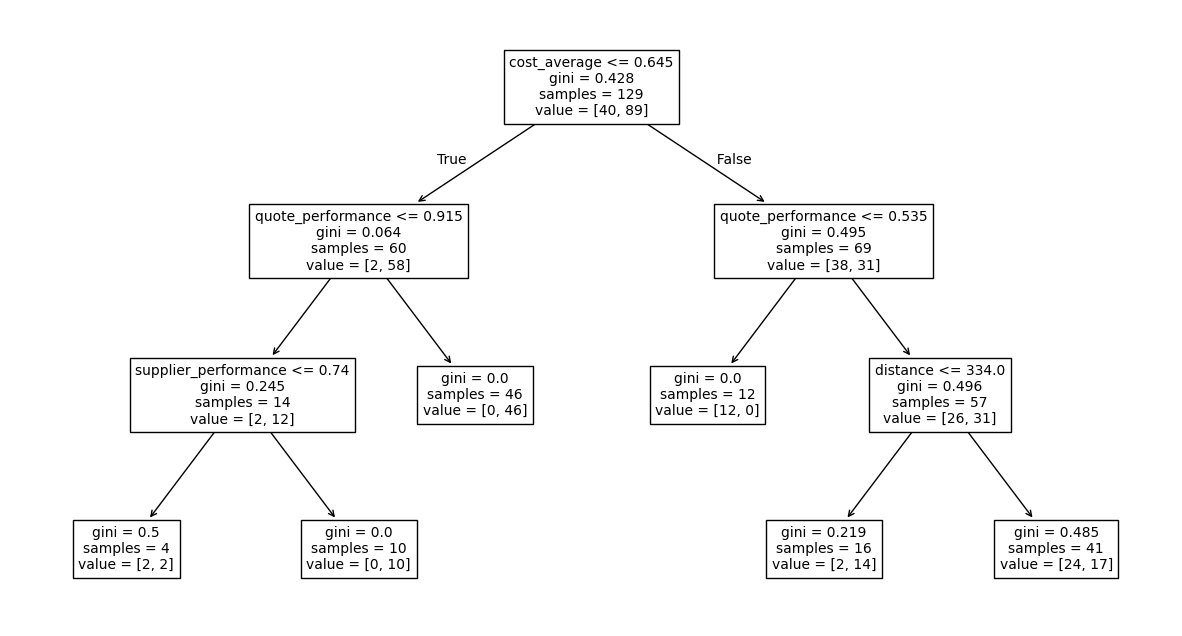

In [37]:
plt.figure(figsize=[15,8])
plot_tree(dtc, feature_names=x1.columns,fontsize=10)

### To pickle

In [38]:
with open("models/acceptance_predictor.pkl", "wb") as f:
    pickle.dump(dtc,f)

## Selection of best offer

In [41]:
df_supplier_quotes['inquiry_id'].value_counts()

inquiry_id
3     10
14    10
18    10
13    10
1      9
16     9
12     9
11     8
20     8
19     8
15     8
5      8
7      8
9      7
4      7
8      7
17     7
6      7
2      6
10     6
Name: count, dtype: int64

In [46]:
df_supplier_quotes[df_supplier_quotes['inquiry_id']==10].sort_values("quality_item_performance",ascending=False).iloc[0,]

supplier_quote_id                                  321
supplier_id                                          6
product_id                                           2
inquiry_id                                          10
cost_average                                      0.47
cost_price                                         0.4
number_days                                          8
distance                                           356
quote_performance                                 1.21
supplier_performance                              0.93
quality_item_performance                         98.74
accepted                                          True
query_date                  2025-02-13 17:15:05.276980
Name: 84, dtype: object

## Function that reads the csv predicts the best offer for a quote

In [59]:
x1_train.shape

(129, 6)

In [89]:
inquiry_id=11
with open('./models/acceptance_predictor.pkl', 'rb') as f:
        dtc = pickle.load(f)
df_supplier_quotes = pd.read_csv('data/csv/supplier_quotes.csv')
sel_quotes = df_supplier_quotes[df_supplier_quotes['inquiry_id']==inquiry_id].copy()
features = ["cost_average", "cost_price", "number_days", "distance", "quote_performance", "supplier_performance"]
sel_quotes['accept_probability'] = dtc.predict_proba(sel_quotes[features])[:,1].round(2)
best_quote = sel_quotes.sort_values(['accept_probability','cost_average','number_days','distance'],ascending=[False,True,True,True]).iloc[0,:]
best_quote
print(f'''
      The best offer of inquiry {inquiry_id} is the one by supplier {best_quote['supplier_id']}, with a normalized cost of {best_quote['cost_average']}.
      They can deliver the product in {best_quote['number_days']} days and the acceptance probability of the quote by the customer is
      {best_quote['accept_probability']*100} %.
      ''')


      The best offer of inquiry 11 is the one by supplier 8, with a normalized cost of 0.51.
      They can deliver the product in 10 days and the acceptance probability of the quote by the customer is
      100.0 %.
      


In [5]:
from src import model as md
import numpy as np

In [2]:
md.best_offer(5)


        The best offer of inquiry 5 is the one by supplier 10, with a normalized cost of 0.42.
        They can deliver the product in 6 days and the acceptance probability of the quote by the customer is
        100.0 %.
        


In [12]:
for i in range(1,20):
    md.best_offer(i)
    print("="*20)


        The best offer of inquiry 1 is the one by supplier 5, with a normalized cost of 0.49.
        They can deliver the product in 9 days and the acceptance probability of the quote by the customer is
        100.0 %.
        

        The best offer of inquiry 2 is the one by supplier 6, with a normalized cost of 0.55.
        They can deliver the product in 11 days and the acceptance probability of the quote by the customer is
        100.0 %.
        

        The best offer of inquiry 3 is the one by supplier 8, with a normalized cost of 0.42.
        They can deliver the product in 6 days and the acceptance probability of the quote by the customer is
        100.0 %.
        

        The best offer of inquiry 4 is the one by supplier 10, with a normalized cost of 0.45.
        They can deliver the product in 7 days and the acceptance probability of the quote by the customer is
        100.0 %.
        

        The best offer of inquiry 5 is the one by supplier 10, with a nor

In [8]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])